In [40]:
import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

In [5]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

## Load data

In [11]:
adata_chen = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.h5ad')

In [ ]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)
chen_patient_metadata = chen_patient_metadata[(chen_patient_metadata['Cancer Type'] == 'CRC') & 
                                            (chen_patient_metadata['MSI/MSS']=='MSI') & 
                                            (chen_patient_metadata['Response']!='SD') & 
                                            ~(chen_patient_metadata['Patient ID'].isin(['P08', 'P12']))].reset_index(drop=True)
chen_patient_metadata

In [13]:
dict_Identifier_to_lvl_1_CellType_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl1.pickle')
dict_Identifier_to_lvl_1_CellType_2 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl1.pickle')
dict_Identifier_to_lvl_1_CellType_3 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl1.pickle')

dict_Identifier_to_lvl_2_CellType_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl2.pickle')
dict_Identifier_to_lvl_2_CellType_2 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl2.pickle')
dict_Identifier_to_lvl_2_CellType_3 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl2.pickle')

dict_Identifier_to_lvl_1_CellType_Total,  dict_Identifier_to_lvl_2_CellType_Total = dict(), dict()

for k,v in dict_Identifier_to_lvl_1_CellType_1.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_1_CellType_2.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_1_CellType_3.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v

for k,v in dict_Identifier_to_lvl_2_CellType_1.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_2_CellType_2.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_2_CellType_3.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v

In [14]:
lvl1_celltype = list()
lvl2_celltype = list()

for tup in adata_chen.obs.itertuples():
    if tup.Manual_CellType_lvl_1 == 'Tumor epithelial':
        lvl1_celltype.append('Epithelial')
        lvl2_celltype.append('Tumor epithelial')
    elif tup.Manual_CellType_lvl_1 == 'Normal epithelial':
        lvl1_celltype.append('Epithelial')
        lvl2_celltype.append(dict_Identifier_to_lvl_2_CellType_Total[tup.Identifier])
    else:
        lvl1_celltype.append(dict_Identifier_to_lvl_1_CellType_Total[tup.Identifier])
        lvl2_celltype.append(dict_Identifier_to_lvl_2_CellType_Total[tup.Identifier])
    

In [15]:
adata_chen.obs['Manual_CellType_lvl_1'] = lvl1_celltype
adata_chen.obs['Manual_CellType_lvl_2'] = lvl2_celltype

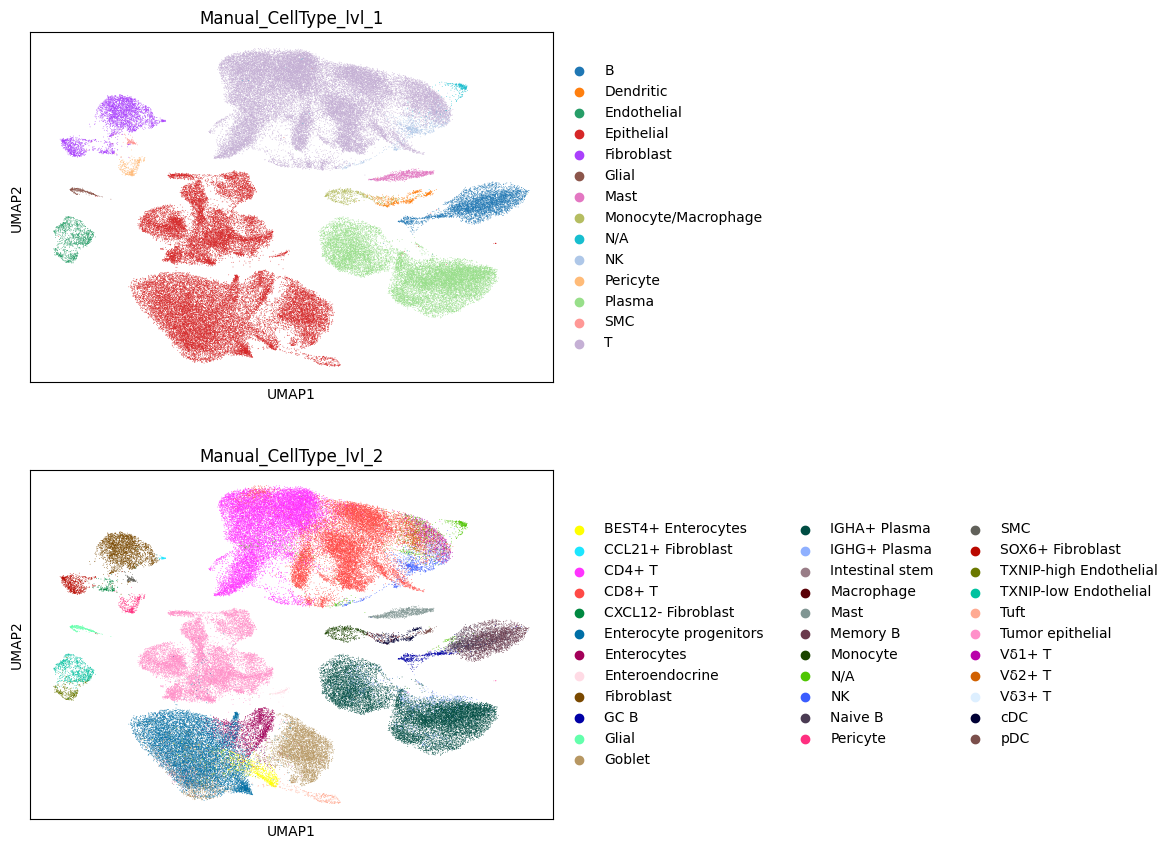

In [17]:
sc.pl.umap(adata_chen, color=['Manual_CellType_lvl_1', 'Manual_CellType_lvl_2'], ncols=1)

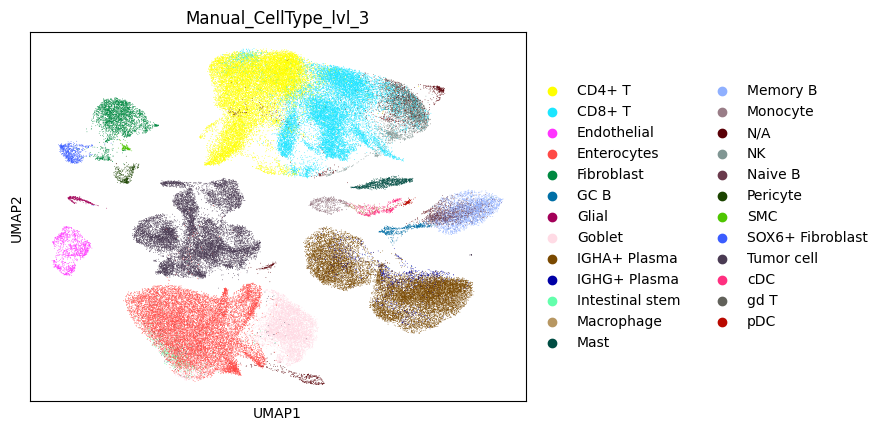

In [35]:
# Manual_CellType_lvl_1
Chen_exclusive_lvl_2_CellTypes = {
    # Simple name change
    'BEST4+ Enterocytes' : 'Enterocytes',
    'Stem' : 'Intestinal stem cell', 
    'Tumor epithelial' : 'Tumor cell',
    
    # Exclusive cell types
    'CCL21+ Fibroblast' : 'Fibroblast',
    'CXCL12- Fibroblast' : 'Fibroblast',
    'Enterocyte progenitors' : 'Enterocytes',
    'Enteroendocrine' : 'N/A',  #!
    'TXNIP-high Endothelial' : 'Endothelial',
    'TXNIP-low Endothelial' : 'Endothelial',
    'Tuft'  : 'N/A',            #!
    # 'Vδ3+ T' : 'Vδ3+ T',
    'Vδ1+ T' : 'gd T',
    'Vδ2+ T' : 'gd T',
    'Vδ3+ T' : 'gd T',

}

dict_Identifier_to_lvl_3_CellType = dict()
for tup in adata_chen.obs.itertuples():
    try:
        dict_Identifier_to_lvl_3_CellType[tup.Identifier] = Chen_exclusive_lvl_2_CellTypes[tup.Manual_CellType_lvl_2]
    except KeyError:
        dict_Identifier_to_lvl_3_CellType[tup.Identifier] = tup.Manual_CellType_lvl_2
adata_chen.obs['Manual_CellType_lvl_3'] = [ dict_Identifier_to_lvl_3_CellType[Identifier] for Identifier in adata_chen.obs['Identifier'] ]

sc.pl.umap(adata_chen, color=['Manual_CellType_lvl_3'])

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


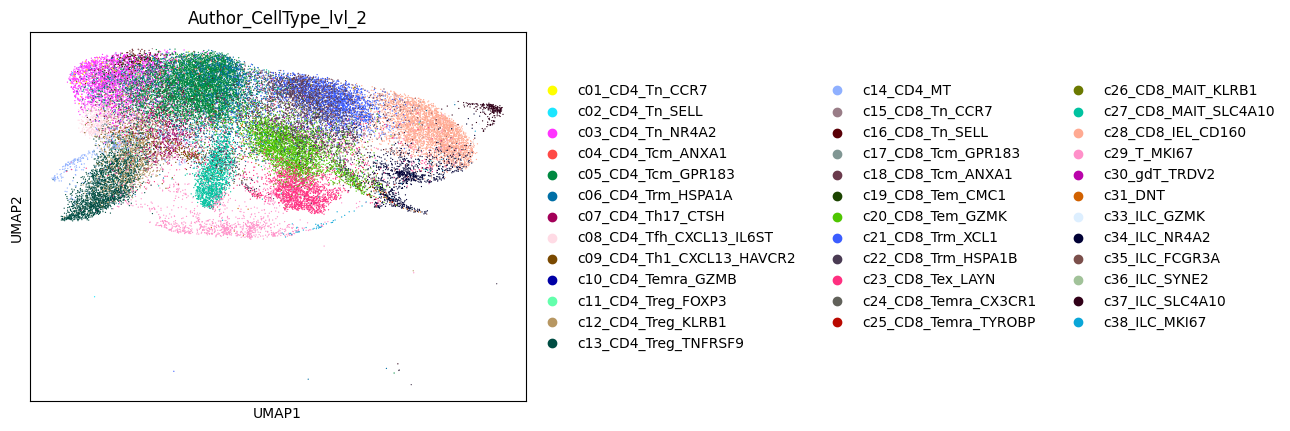

In [221]:
sc.pl.umap(adata_chen[adata_chen.obs['Author_CellType_lvl_1'].isin(['T', 'ILC'])], color=['Author_CellType_lvl_2'])

In [190]:
adata_chen.write('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')

## Association of each TME cell type to MSI intensity

In [36]:
adata_chen_tumorSamples  = adata_chen[adata_chen.obs['BiopsySite']=='Tumor'].copy()
adata_chen_normalSamples = adata_chen[adata_chen.obs['BiopsySite']!='Tumor'].copy()

### Calculate sample enrichment

In [271]:
CellTypeProportionByPatient = list()
PatientID_blacklist = ['P15', 'P26', 'P04' ]
PatientID_blacklist = list()

for PatientID, edf in adata_chen[(adata_chen.obs['Manual_CellType_lvl_3']!='Tumor cella') & 
                                 (adata_chen.obs['MSI']=='MSI') & 
                                 (adata_chen.obs['Manual_CellType_lvl_3']!='N/A') & 
                                 ~(adata_chen.obs['PatientID'].isin(PatientID_blacklist))].obs.groupby('PatientID', observed=True,):
    for BiopsySite, edf2 in edf.groupby("BiopsySite", observed=True):
        for CellType, edf3 in edf2.groupby('Manual_CellType_lvl_3', observed=True,):    #! Author_CellType_lvl_2    Manual_CellType_lvl_3
            if CellType == 'N/A': continue 
            
            if CellType == 'CD4+ T' and PatientID=='P04': 
                pass 
            
            CellTypeProportionByPatient.append( [PatientID, edf.iloc[0].MSI, BiopsySite, CellType, len(edf3), len(edf3)/len(edf2) ] )
            
CellTypeProportionByPatient = pd.DataFrame(CellTypeProportionByPatient, columns=['PatientID', 'MSI',  'BiopsySite', 'CellType', 'Count', 'Proportion'])
CellTypeProportionByPatient.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellTypeProportion.tsv', sep='\t', index=False)

In [30]:
def calcSampleEnrichment( T_Proportion, N_Proportion, epsilon=(0.1)**6 ):
    return np.log2( (T_Proportion+epsilon)/(N_Proportion+epsilon) )

In [262]:
SampleEnrichmentByCellType = list()
T_totalCellCount = sum(CellTypeProportionByPatient[CellTypeProportionByPatient['BiopsySite']=='Tumor']['Count'])
N_totalCellCount = sum(CellTypeProportionByPatient[CellTypeProportionByPatient['BiopsySite']=='Normal']['Count'])
print(T_totalCellCount, N_totalCellCount)
dict_BiopsySite_to_TotalCount = { 'Tumor' : T_totalCellCount,'Normal' : N_totalCellCount }

for CellType, edf in CellTypeProportionByPatient.groupby('CellType'):
    # dict_BiopsySite_to_Proportion = { tup.BiopsySite : tup.Proportion for tup in edf.itertuples() }
    dict_BiopsySite_to_Proportion = { BiopsySite : sum(edf2['Count'])/dict_BiopsySite_to_TotalCount[BiopsySite] for BiopsySite, edf2 in edf.groupby('BiopsySite') }
    if 'Tumor' not in list(dict_BiopsySite_to_Proportion.keys()): dict_BiopsySite_to_Proportion['Tumor'] = 0 
    if 'Normal' not in list(dict_BiopsySite_to_Proportion.keys()): dict_BiopsySite_to_Proportion['Normal'] = 0 

    SampleEnrichmentByCellType.append( [CellType, calcSampleEnrichment(dict_BiopsySite_to_Proportion['Tumor'], dict_BiopsySite_to_Proportion['Normal'])] )
SampleEnrichmentByCellType = pd.DataFrame(SampleEnrichmentByCellType, columns=['CellType', 'Enrichment'])

32072 52516


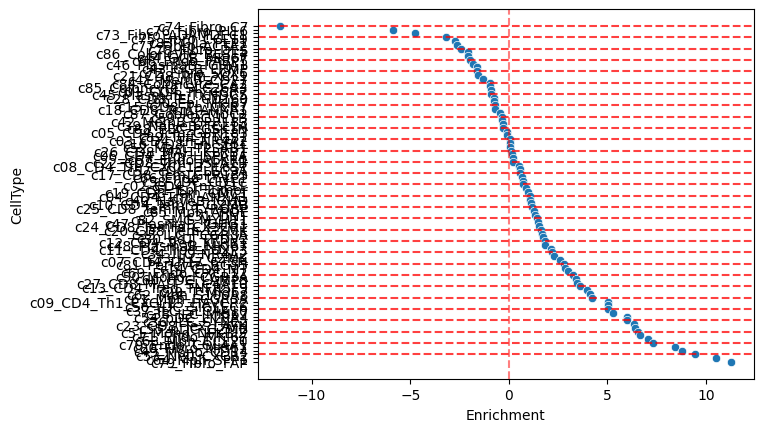

In [224]:
sns.scatterplot(data=SampleEnrichmentByCellType.sort_values('Enrichment'), y='CellType', x='Enrichment')
plt.axvline(0, color='r', ls='--', alpha=0.5,)
for i in range(0, len(SampleEnrichmentByCellType), 3):
    plt.axhline(i, color='r', ls='--', alpha=0.75)

### Calculate association between proportion and MSI intensity

In [263]:
list_PatientID = list(set(adata_chen.obs['PatientID']))
dict_PatientID_to_MSI_intensity = { PatientID : np.mean(edf[(edf['Manual_CellType_lvl_2']=='Tumor epithelial')]['MSI_score']) for PatientID, edf in adata_chen.obs.groupby('PatientID', ) } 
AssociationWithMSIByCellType = list()

for CellType, edf in CellTypeProportionByPatient[CellTypeProportionByPatient['BiopsySite']=='Tumor'].groupby('CellType', observed=True,):
    dict_PatientID_to_Proportion = { tup.PatientID : tup.Proportion for tup in edf.itertuples() }
    # if len(edf) != len(list_PatientID): 
    #     print(CellType)
    #     continue
    c = 0
    for PatientID in list_PatientID:
        try: dict_PatientID_to_Proportion[PatientID]
        except KeyError: 
            c += 1
            dict_PatientID_to_Proportion[PatientID] = 0
            

    x, y = [ dict_PatientID_to_Proportion[p] for p in list_PatientID ], [ dict_PatientID_to_MSI_intensity[p] for p in list_PatientID ]
    r, pval = scipy.stats.pearsonr( x, y, )
    AssociationWithMSIByCellType.append( [CellType, r, pval, len(list_PatientID)-c] )

AssociationWithMSIByCellType = pd.DataFrame(AssociationWithMSIByCellType, columns=['CellType', 'R', 'pval', 'n_patients'])

/tmp/ipykernel_124485/2008732167.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_MSI_intensity = { PatientID : np.mean(edf[(edf['Manual_CellType_lvl_2']=='Tumor epithelial')]['MSI_score']) for PatientID, edf in adata_chen.obs.groupby('PatientID', ) }


In [264]:
dict_CellType_to_SummarizedInfo = dict()
for tup in SampleEnrichmentByCellType[SampleEnrichmentByCellType['CellType'].isin( AssociationWithMSIByCellType['CellType'] )].itertuples():
    dict_CellType_to_SummarizedInfo[tup.CellType] = [tup.Enrichment] 
for tup in AssociationWithMSIByCellType[AssociationWithMSIByCellType['CellType'].isin( SampleEnrichmentByCellType['CellType'] )].itertuples():
    dict_CellType_to_SummarizedInfo[tup.CellType].append( tup.R )
    dict_CellType_to_SummarizedInfo[tup.CellType].append( tup.pval )
    dict_CellType_to_SummarizedInfo[tup.CellType].append( tup.n_patients )

SummarizedInfo = pd.DataFrame(dict_CellType_to_SummarizedInfo).T
SummarizedInfo.reset_index(inplace=True)
SummarizedInfo.columns = ['CellType', 'TissueEnrichment', 'CorrelationWithMSI', 'Pvalue', 'n_patients']

In [265]:
SummarizedInfo['n_patients'] = [ int(e) for e in SummarizedInfo['n_patients'] ]
SummarizedInfo.sort_values('Pvalue')

,CellType,TissueEnrichment,CorrelationWithMSI,Pvalue,n_patients
14,Monocyte,5.307668,-0.623933,0.053872,10
11,Macrophage,1.285646,-0.578949,0.079484,10
15,NK,1.938060,0.537684,0.108932,10
20,cDC,0.549694,0.431235,0.213391,10
22,pDC,6.402406,-0.328721,0.353716,9
13,Memory B,-0.442772,0.297336,0.404094,9
2,Endothelial,2.371028,-0.296520,0.405447,10
0,CD4+ T,0.893267,0.296451,0.405562,10
6,Glial,-2.722160,0.274403,0.442935,3
12,Mast,0.066225,-0.164282,0.650176,10


In [266]:
dict_CellType_to_TotalCount = { CellType : sum(edf['Count']) for CellType, edf in CellTypeProportionByPatient.groupby('CellType') }
SummarizedInfo['TotalCellCount'] = [ dict_CellType_to_TotalCount[CellType] for CellType in SummarizedInfo['CellType'] ]

In [267]:
SummarizedInfo[(SummarizedInfo['TissueEnrichment']>=0) & 
               (SummarizedInfo['Pvalue']<=0.2) & 
               (SummarizedInfo['TotalCellCount']>=100)].sort_values('CorrelationWithMSI', ascending=False).head(20)

,CellType,TissueEnrichment,CorrelationWithMSI,Pvalue,n_patients,TotalCellCount
15,NK,1.938060,0.537684,0.108932,10,932
11,Macrophage,1.285646,-0.578949,0.079484,10,122
14,Monocyte,5.307668,-0.623933,0.053872,10,505


In [268]:
palette_e=[
    'lightcoral', 'tomato' ,'darkred',          # red x 3
    'chocolate', 'darkorange', 'navajowhite',   # orange x 3
    'darkgoldenrod', 'gold',                    # yellow x 2
    'black', 'dimgrey',                         # black x 2
    'yellowgreen', 'darkolivegreen', 'lawngreen', 'forestgreen', # green x 4
    'darkslategrey', 'cyan', 'deepskyblue', 'dodgerblue', # blue x 5
    'mediumslateblue', 'indigo', 'magenta',             # other x 2 
]

/tmp/ipykernel_124485/1237880459.py:2: UserWarning: The palette list has more values (21) than needed (12), which may not be intended.
  ax = sns.scatterplot(data=SummarizedInfo[(SummarizedInfo['TissueEnrichment']>=0)].sort_values('CorrelationWithMSI', ascending=False).head(20),


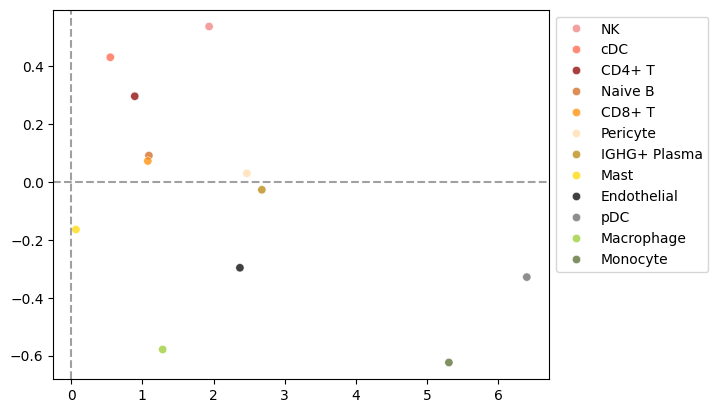

In [270]:
plt.figure(dpi=100)
ax = sns.scatterplot(data=SummarizedInfo[(SummarizedInfo['TissueEnrichment']>=0)].sort_values('CorrelationWithMSI', ascending=False).head(20), 
                     x='TissueEnrichment', y='CorrelationWithMSI', hue='CellType', 
                     # palette=dict_ct_to_color, 
                     palette=palette_e,
                     alpha=0.75,
                     )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='')
plt.axvline(0, color='gray', ls='--', alpha=0.75)
plt.axhline(0, color='gray', ls='--', alpha=0.75)
ax.set_xlabel('');
ax.set_ylabel('');

In [269]:
SummarizedInfo.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellType_MSI_intensity.tsv', sep='\t', index=False)

In [189]:
raise ValueError

ValueError: 

In [ ]:
SummarizedInfo_C = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellType_MSI_intensity.tsv', sep='\t')
SummarizedInfo_J = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/4_TME/CellType_MSI_intensity.tsv', sep='\t')

# SummarizedInfo_C.columns = [ f'{c}_C' for c in SummarizedInfo_C.columns ]
# SummarizedInfo_J.columns = [ f'{c}_J' for c in SummarizedInfo_J.columns ]

/tmp/ipykernel_124485/2298884052.py:18: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=SummarizedInfo_concat[(SummarizedInfo_concat['CorrelationWithMSI_C']<0) &


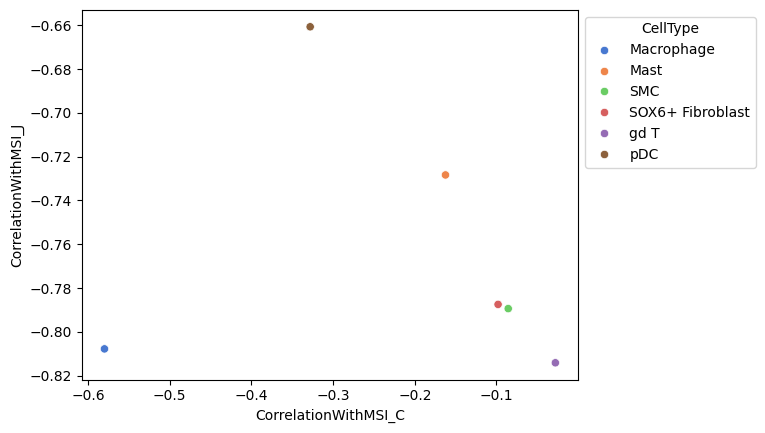

In [ ]:
dict_CellType_to_Info = dict()
for tup in SummarizedInfo_C.itertuples():
    dict_CellType_to_Info[tup.CellType] = [ tup.TissueEnrichment, tup.CorrelationWithMSI, tup.Pvalue, 0, 0, 0 ]
for tup in SummarizedInfo_J.itertuples():
    try:
        dict_CellType_to_Info[tup.CellType][3] = tup.TissueEnrichment
        dict_CellType_to_Info[tup.CellType][4] = tup.CorrelationWithMSI
        dict_CellType_to_Info[tup.CellType][5] = tup.Pvalue
    except KeyError:
        dict_CellType_to_Info[tup.CellType] = [ 0,0,0, tup.TissueEnrichment, tup.CorrelationWithMSI, tup.Pvalue ]

SummarizedInfo_concat = pd.DataFrame(dict_CellType_to_Info,).T
SummarizedInfo_concat.reset_index(inplace=True)
SummarizedInfo_concat.columns = ['CellType', 
                                 'TissueEnrichment_C', 'CorrelationWithMSI_C', 'pvalue_C', 
                                 'TissueEnrichment_J', 'CorrelationWithMSI_J', 'pvalue_J']

ax = sns.scatterplot(data=SummarizedInfo_concat[(SummarizedInfo_concat['CorrelationWithMSI_C']<0) & 
                                                (SummarizedInfo_concat['CorrelationWithMSI_J']<0)], 
                     x='CorrelationWithMSI_C', y='CorrelationWithMSI_J', hue='CellType', 
                     palette=sns.color_palette('muted')+sns.color_palette('bright'))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
joanito_patient_order_by_MSI_intensity  = ['CRC2817', 'CRC2783', 'SC035', 'SC044']

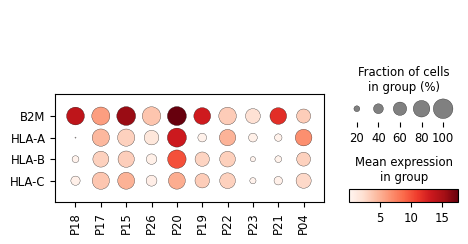

In [ ]:
sc.pl.dotplot(adata_chen[adata_chen.obs['Manual_CellType_lvl_3']=='Tumor cell'], 
              var_names=['B2M', 'HLA-A', 'HLA-B', 'HLA-C'], groupby='PatientID', categories_order=chen_patient_order_by_MSI_intensity, swap_axes=True,)

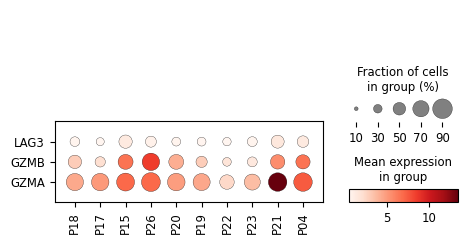

In [ ]:
sc.pl.dotplot(adata_chen[adata_chen.obs['Manual_CellType_lvl_3']=='CD8+ T'], 
              var_names=['LAG3', 'GZMB', 'GZMA', 'GZM'], groupby='PatientID', categories_order=chen_patient_order_by_MSI_intensity, swap_axes=True,)

<Axes: xlabel='count', ylabel='Author_CellType_lvl_2'>

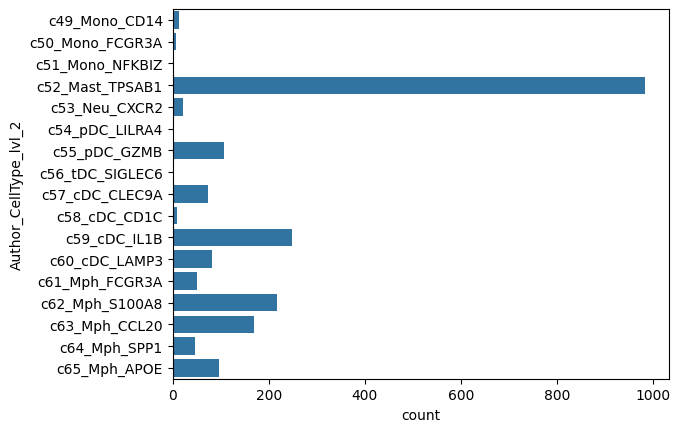

In [ ]:
sns.countplot(data=adata_chen[adata_chen.obs['Author_CellType_lvl_1']=='Mye'].obs, y='Author_CellType_lvl_2', 
               # hue='PatientID', 
              )
# sns.countplot(data=adata_chen[adata_chen.obs['Author_CellType_lvl_1']=='Mye'].obs, y='PatientID', 
#               order=chen_patient_order_by_MSI_intensity, hue='Response'
#               )

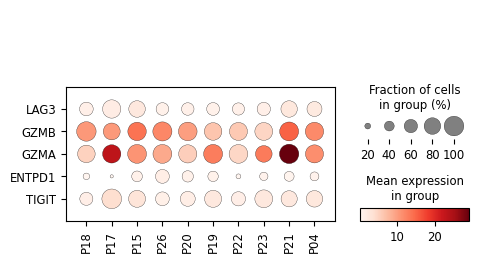

In [ ]:
sc.pl.dotplot(adata_chen[adata_chen.obs['Author_CellType_lvl_2']=='c23_CD8_Tex_LAYN'], 
              var_names=['LAG3', 'GZMB', 'GZMA', 'ENTPD1', 'TIGIT'], groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity, 
              swap_axes=True,)

<Axes: xlabel='count', ylabel='PatientID'>

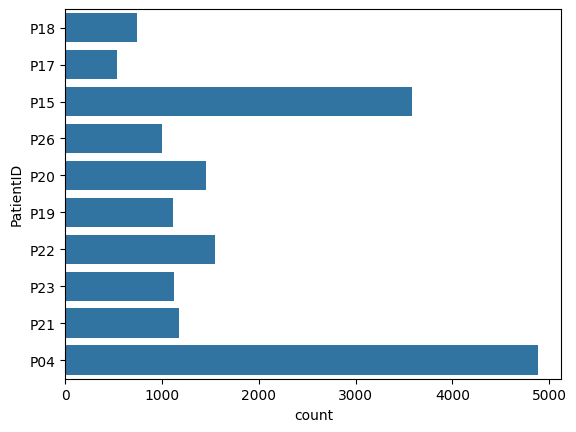

In [ ]:
# sc.pl.umap(adata_chen[adata_chen.obs['Manual_CellType_lvl_3']=='Macrophage'], color=['PatientID'])
sns.countplot(data=adata_chen[adata_chen.obs['Manual_CellType_lvl_3']=='CD4+ T'].obs, y='PatientID', order=chen_patient_order_by_MSI_intensity)